In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random

plt.rc('text', usetex=True)  # Abilita l'uso di LaTeX in tutte le stringhe di testo
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'


First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

(35.0, 50.0)

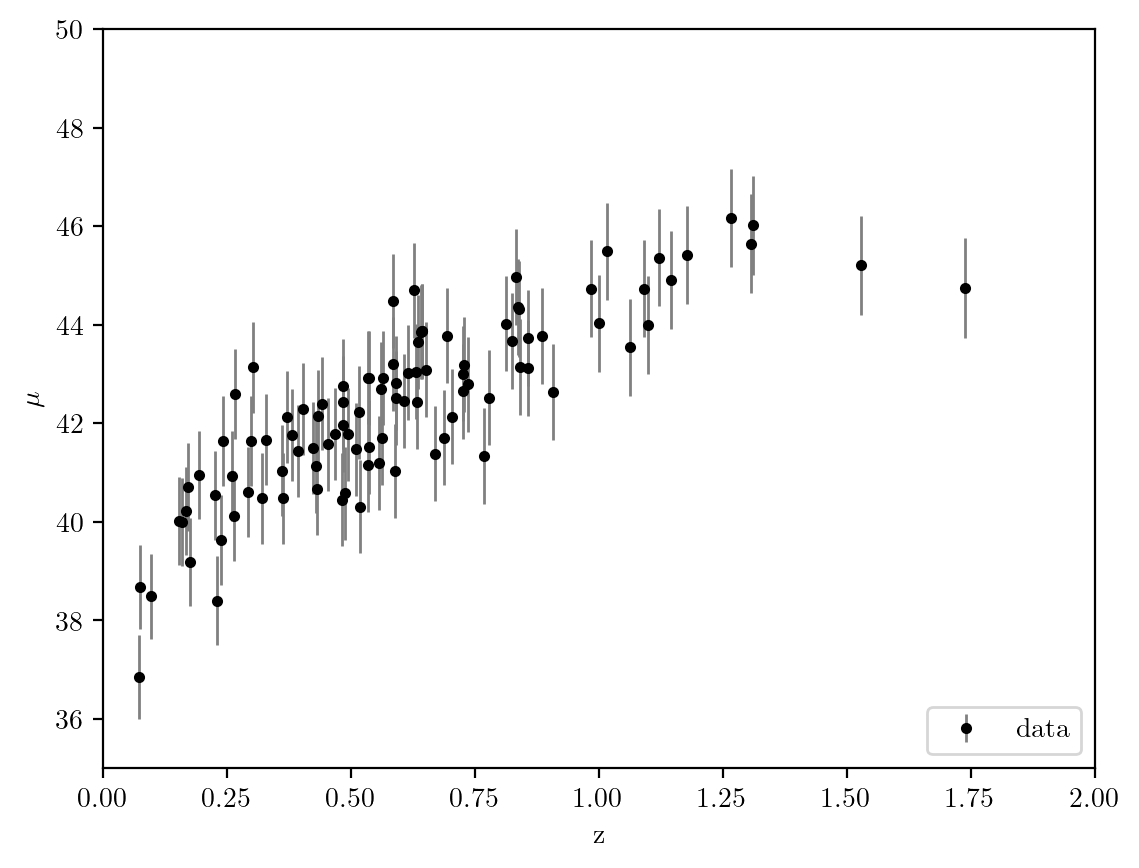

In [3]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)